In [3]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints

from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc import MCMC

import arviz as az
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

assert pyro.__version__.startswith('1.8.6')
torch.set_default_dtype(torch.float32)
torch.set_default_device('cpu')
pyro.set_rng_seed(50)
torch.manual_seed(50)

## Problem B1.1

First we define a function used visualize the GPs and the data.

In [69]:
# Function taken from https://pyro.ai/examples/gp.html with some modifications
def plot(
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,
    plot_predictions=False,
    posterior_test=None,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if X_train is not None and y_train is not None:
        ax.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
    if X_test is not None and y_test is not None:
        ax.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
        plt.legend()
    if plot_predictions:
        Xtest = torch.linspace(0, 1.0, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if posterior_test is not None:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(X_test, full_cov=True)
            else:
                mean, cov = model(X_test, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(X_test.numpy(), mean.numpy(), "o")  # plot the mean
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(0.0, 1.0, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    
    ax.set_xlim(-0.2, 1.2)
    
# function to plot the loss curve
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

Next we generate a dataset and plot it to get an intuition of what we are working with

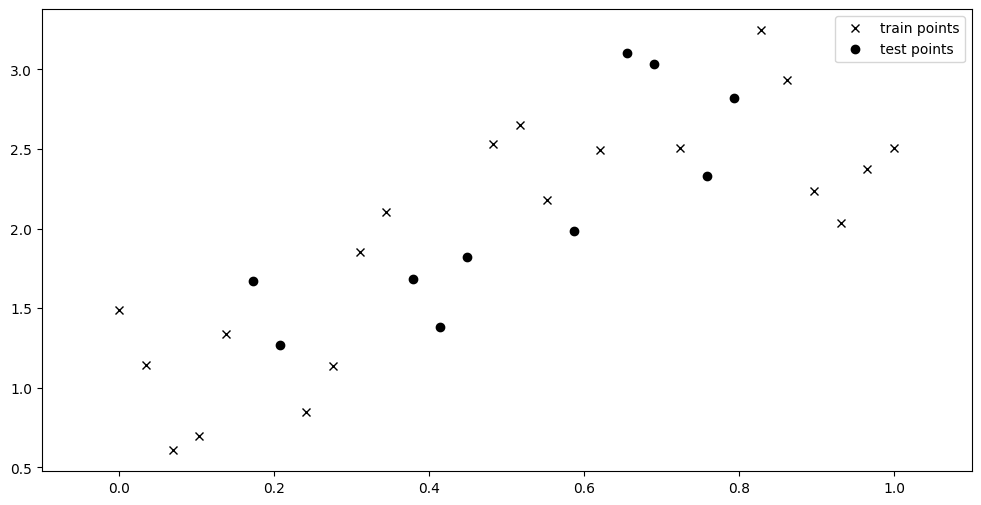

In [5]:
# generate data and plot it
N = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(30 - 1)
    X.append(xi)

X = torch.tensor(X)
noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 3/2 + noise

# split into train and test
indices = torch.randperm(len(X))[:20]
first = torch.arange(0, 30, 1)
diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]

X_train = X[indices]
y_train = y[indices]

X_test = X[diff]
y_test = y[diff]



plot(X_train, y_train, X_test, y_test)  # let's plot the observed data
_ = plt.xlim((-0.1, 1.1))

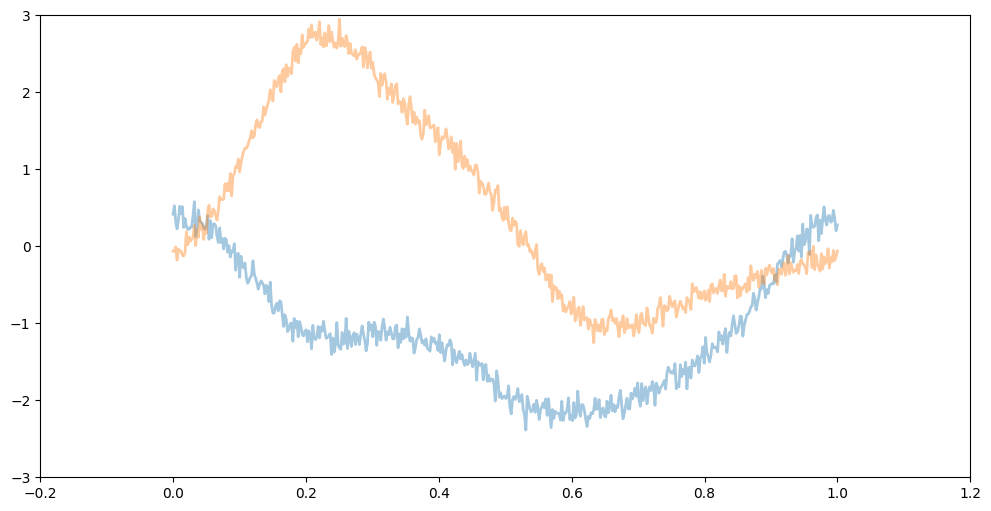

In [6]:
# define kernel with some values and visualize it
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1.0),
    lengthscale=torch.tensor(1.0),
    period=torch.tensor(1.0) 
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# plot to see
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-3, 3))

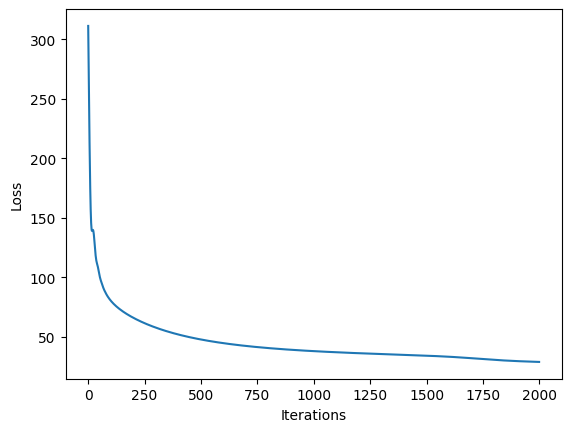

In [94]:
# now lets set some priors
pyro.clear_param_store()

# define model
kernel = gp.kernels.Periodic(
    input_dim=1
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# set prior mean and variance for each param
mu = 0.
var = 0.5

# set priors on the kernel
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)

# perform gradient descent to optimize parameters
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

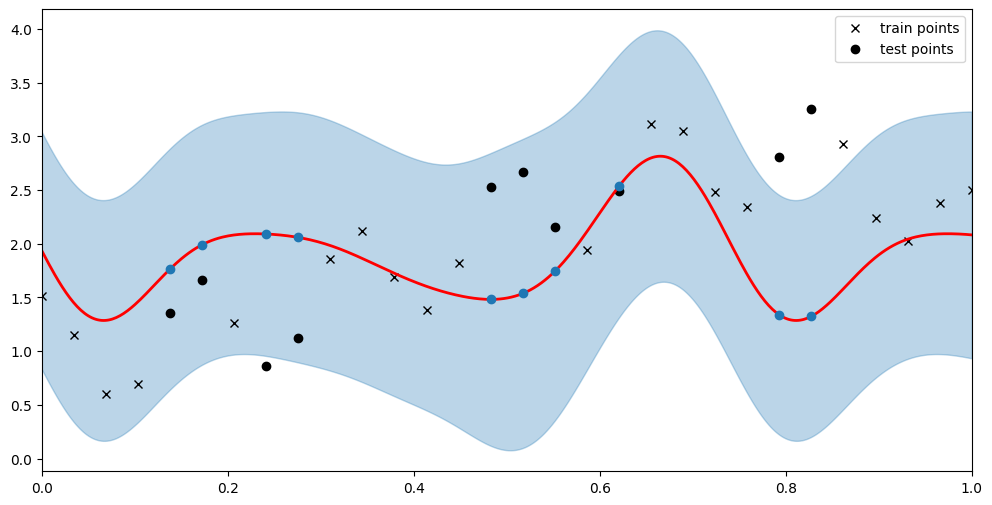

In [95]:
plot(model=gpr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_predictions=True, posterior_test=X_test)
_ = plt.xlim(0, 1)

In [96]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("period = {}".format(gpr.kernel.period))
print("noise = {}".format(gpr.noise))

variance = 1.3479304313659668
lengthscale = 0.8585770726203918
period = 0.7446354627609253
noise = 0.25096064805984497


In [11]:
# function to compute the negative log likelihood
def logLikelihood(params, gpr, X, y, prior):
    l = y.shape[0]
    noise_y = gpr.noise
    K = gpr.kernel(X, X)
    sigma_y_I = noise_y * torch.eye(l)
    inverse = torch.linalg.inv((sigma_y_I + K))
    det = torch.linalg.det((sigma_y_I + K))
    sqrt = torch.sqrt(2 * torch.pi)

    evidence_ll = -0.5 * (y.T @ inverse @ y + torch.log(det) + l * torch.log(sqrt))
    prior_prob = prior.log_prob(params)

    return -evidence_ll - prior_prob

In [97]:
# sample using NUTS
n_samples = 250
n_chains = 2
n_warmup = 200

pyro.clear_param_store()
# compute second moment quantity
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples,
                       num_chains=n_chains)
mcmc.run()

Warmup [1]:   0%|          | 0/500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/500 [00:00, ?it/s]

/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can'

/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      1.64      0.64      1.52      0.83      2.56    248.48      1.00
       kernel.period      1.93      0.77      1.71      0.99      3.10    222.83      1.00
     kernel.variance      1.53      0.72      1.36      0.61      2.43    265.30      1.01

Number of divergences: 0
None


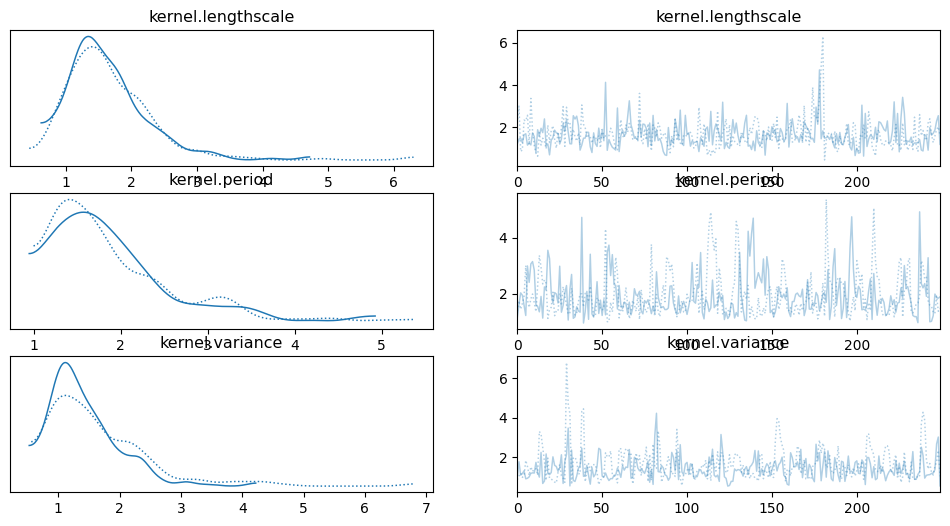

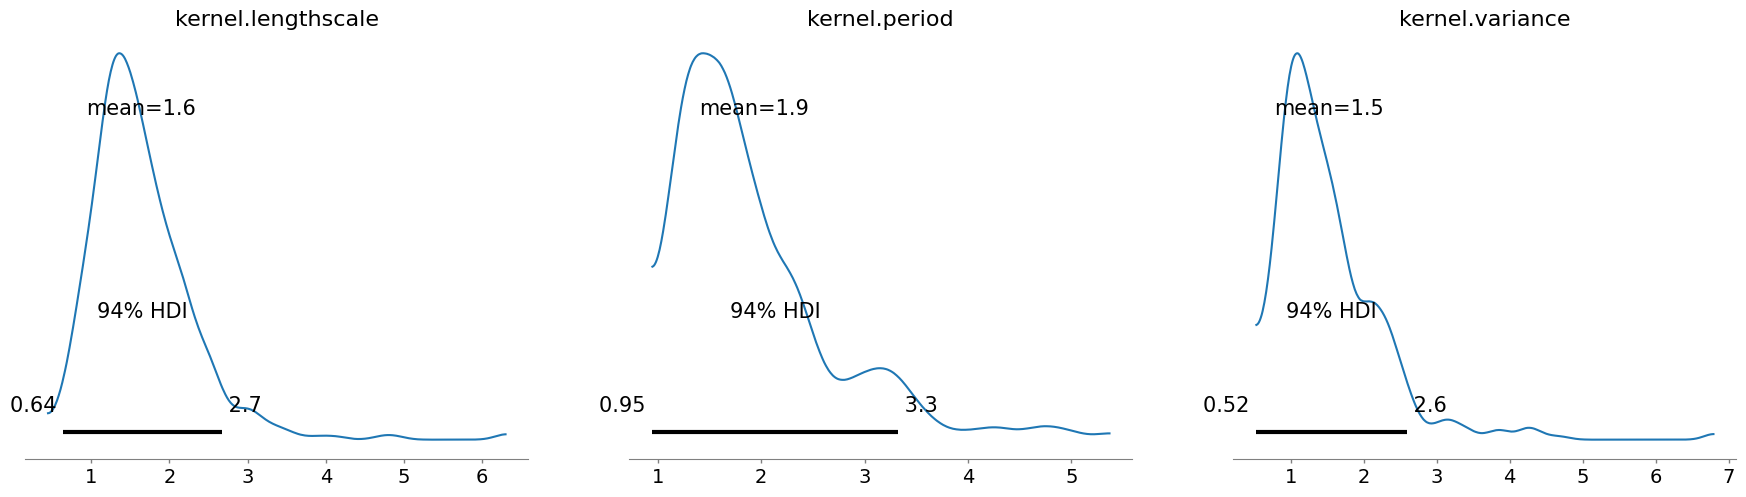

In [98]:
# inspect posterior
samples = mcmc.get_samples()
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)


print(mcmc.summary())
az.plot_trace(sample_data)
plt.show()
az.plot_posterior(sample_data)
plt.show()

In [67]:
means = []
linspace = torch.linspace(0, 1, 101)

vars = 0
for i in range(500):
    gpr.kernel.lengthscale = samples['kernel.lengthscale'][i]
    gpr.kernel.variance = samples['kernel.variance'][i]
    gpr.kernel.period = samples['kernel.period'][i]

    mean, var = gpr(linspace, full_cov=True, noiseless=False)
    means.append(mean.detach().cpu().numpy())
    vars += var


means = np.mean(np.array(means), axis=0)
vars = vars / 500

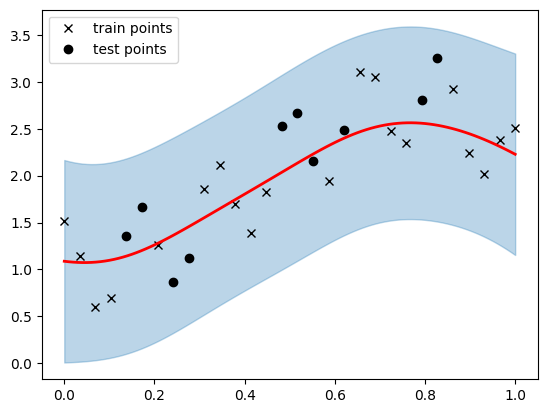

In [68]:
plt.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
plt.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
plt.legend()

sd = vars.diag().sqrt()  # standard deviation at each input point x
plt.plot(linspace.numpy(), means, "r", lw=2)  # plot the mean
plt.fill_between(
            linspace.numpy(),  # plot the two-sigma uncertainty about the mean
            (means - 2.0 * sd.detach().numpy()),
            (means + 2.0 * sd.detach().numpy()),
            color="C0",
            alpha=0.3,
        )
plt.show()

In [73]:
# lets generate 20 datasets
xtrains = []
xtests = []
ytrains = []
ytests = []
indix = []

l = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(l - 1)
    X.append(xi)
X = torch.tensor(X)

for k in range(20):
    # set seeds
    torch.manual_seed(k)
    pyro.set_rng_seed(k)
    
    # generate points
    noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
    y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 1.5 + noise
    
    # split into train and test
    indices = torch.randperm(len(X))[:20]
    first = torch.arange(0, 30, 1)
    diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]
    
    X_train = X[indices]
    y_train = y[indices]
    
    X_test = X[diff]
    y_test = y[diff]
    
    xtrains.append(X_train)
    ytrains.append(y_train)
    xtests.append(X_test)
    ytests.append(y_test)

variance = 1.197948694229126
lengthscale = 1.3911465406417847
period = 1.1497098207473755
noise = 0.1385165899991989
tensor(0.7695)


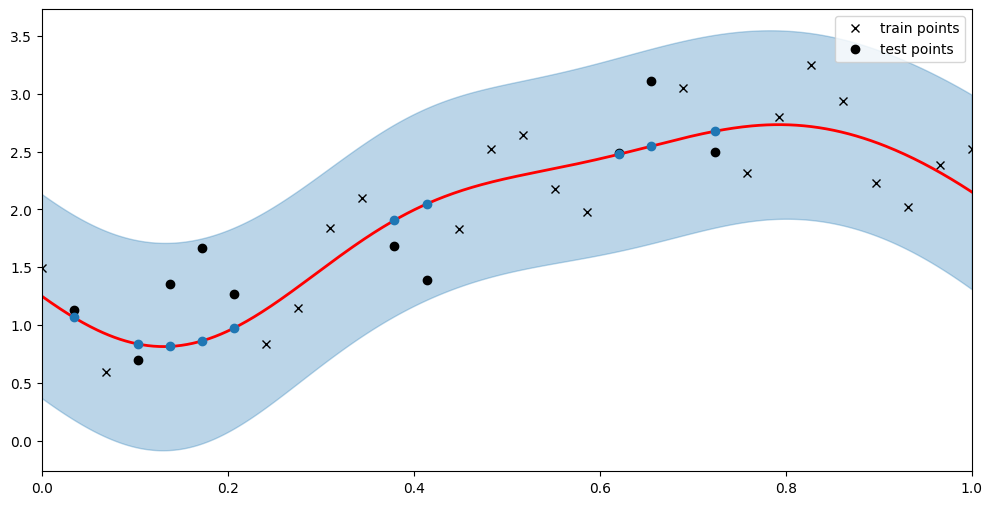

variance = 1.1471283435821533
lengthscale = 1.6514060497283936
period = 1.2649284601211548
noise = 0.12314599752426147
tensor(0.9424)


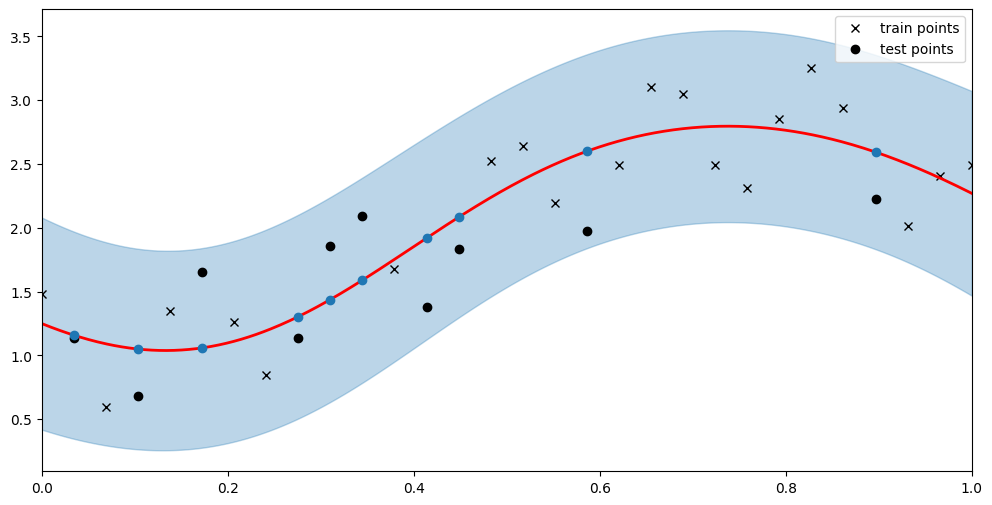

variance = 1.9893234968185425
lengthscale = 0.4157750606536865
period = 1.0778001546859741
noise = 0.0074613397009670734
tensor(2.2804)


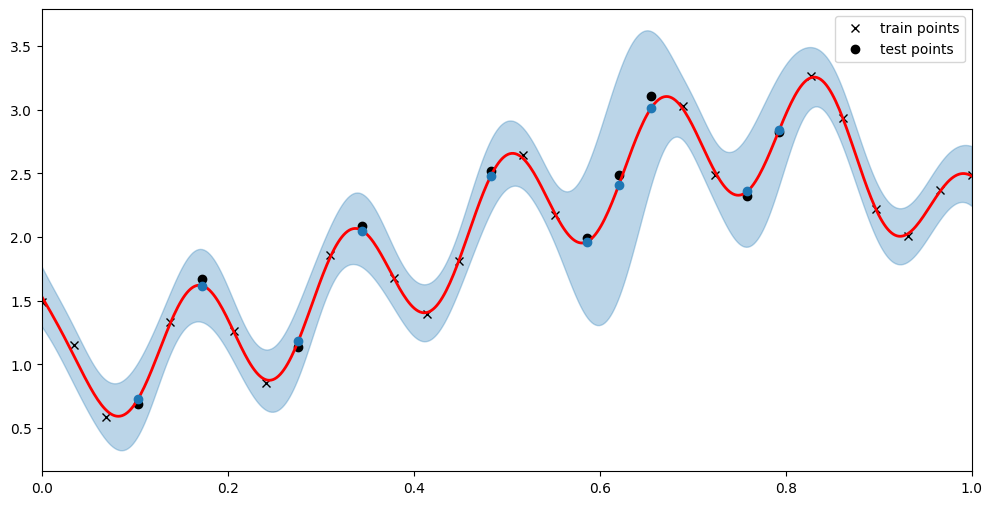

variance = 1.8802708387374878
lengthscale = 0.42807114124298096
period = 1.0707968473434448
noise = 0.012403593398630619
tensor(1.9673)


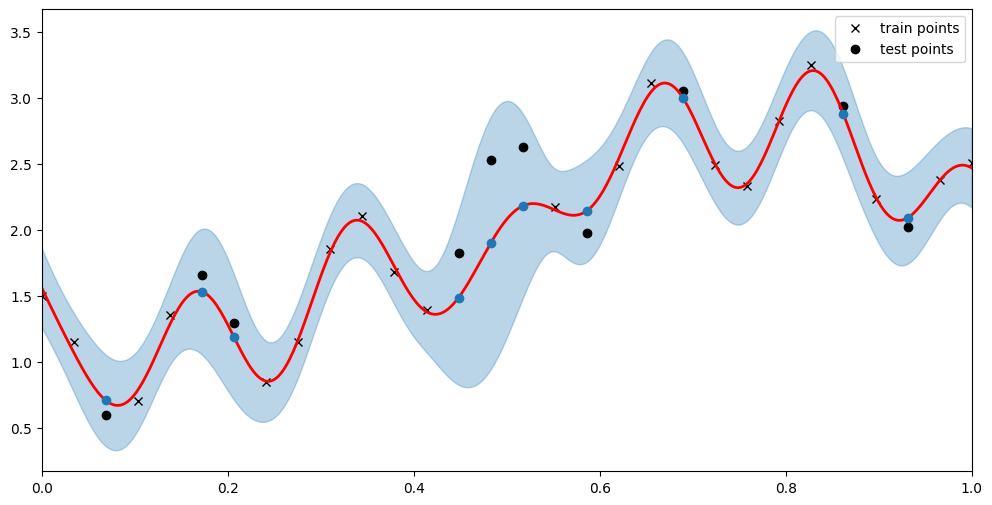

variance = 1.9517914056777954
lengthscale = 0.4194800853729248
period = 1.083748459815979
noise = 0.008540390990674496
tensor(2.2434)


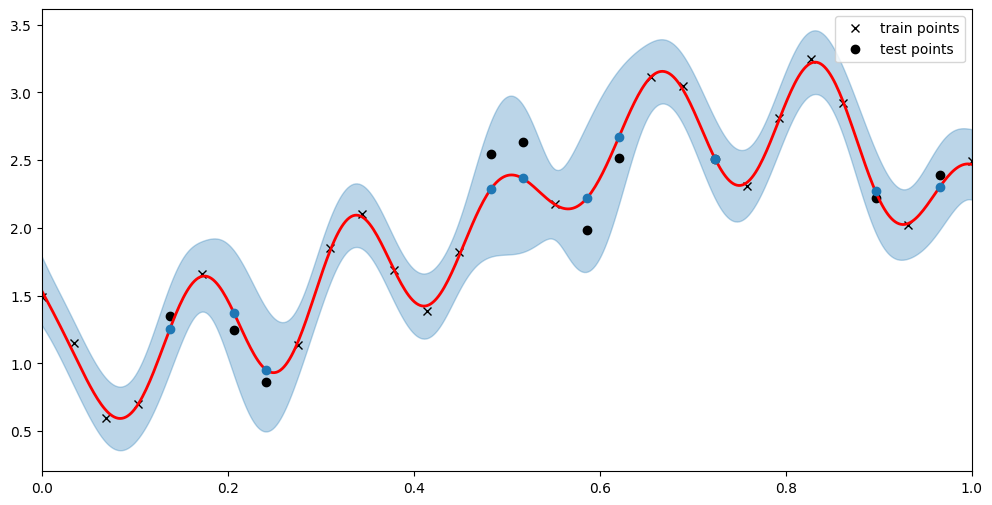

variance = 1.1078147888183594
lengthscale = 1.6396970748901367
period = 1.2871553897857666
noise = 0.13799279928207397
tensor(0.8573)


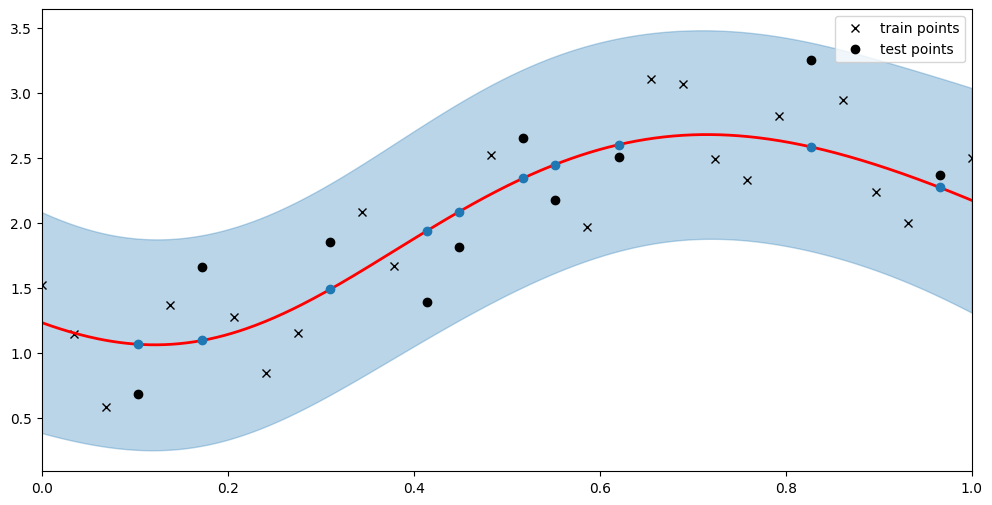

variance = 2.090017080307007
lengthscale = 0.4599234461784363
period = 1.0231178998947144
noise = 0.0009294080082327127
tensor(3.1943)


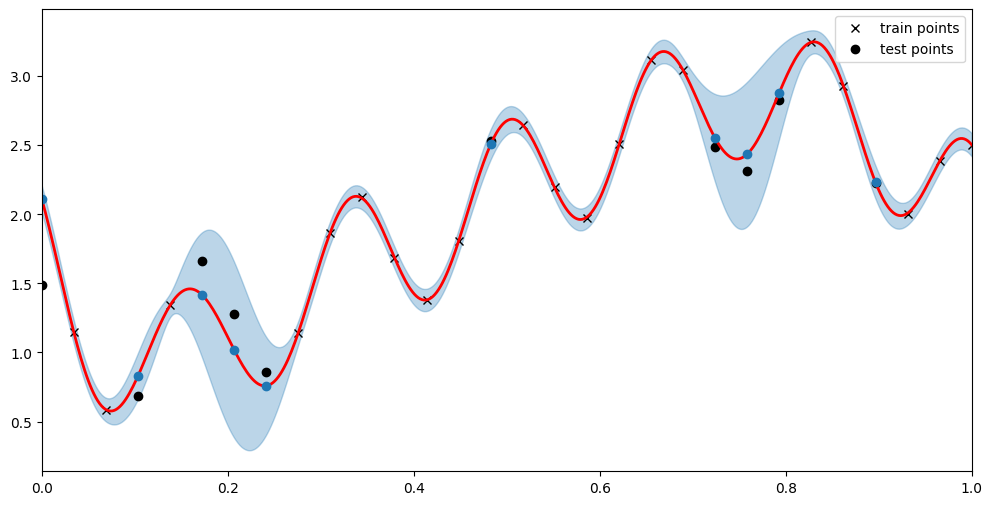

variance = 1.1221423149108887
lengthscale = 1.2872956991195679
period = 1.6390125751495361
noise = 0.220045268535614
tensor(0.4218)


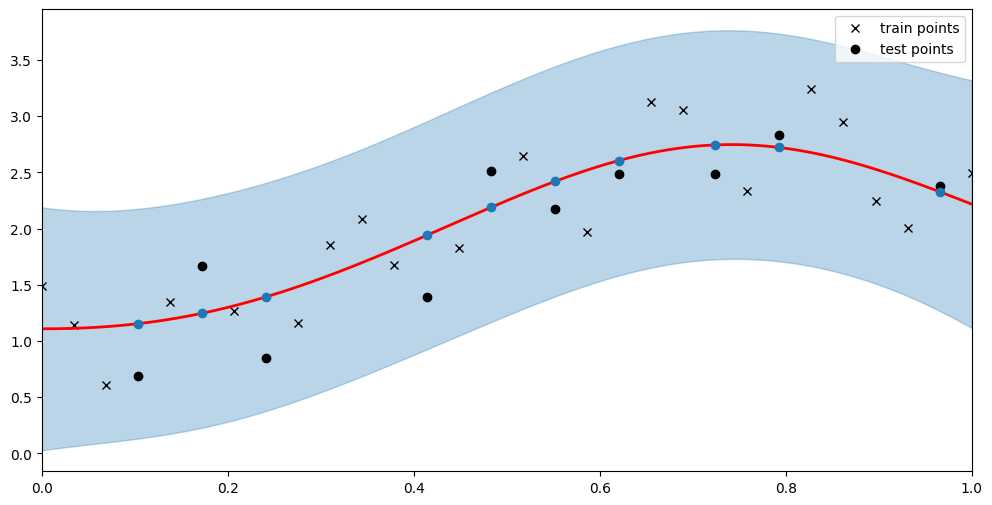

variance = 1.0953543186187744
lengthscale = 1.6261849403381348
period = 1.336938738822937
noise = 0.12805652618408203
tensor(0.9427)


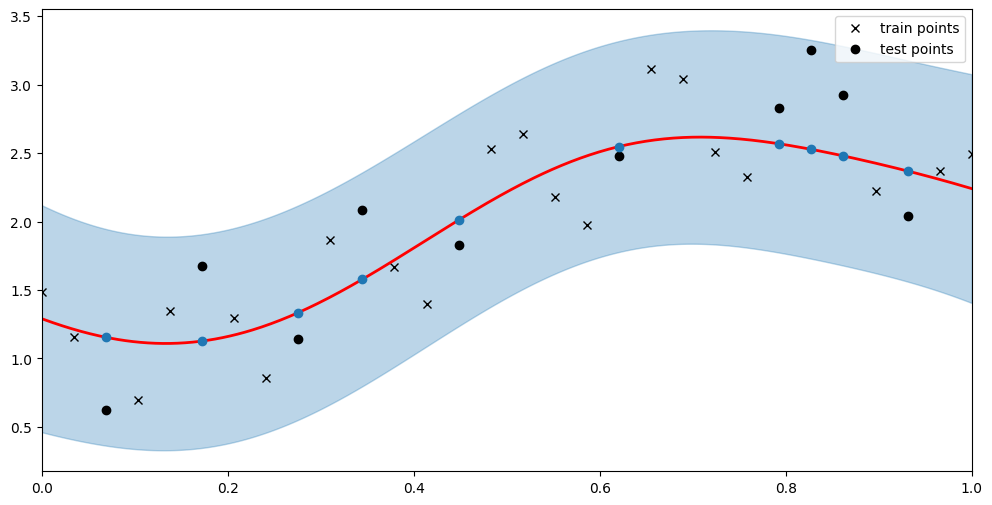

variance = 1.1147538423538208
lengthscale = 1.7280263900756836
period = 1.229295015335083
noise = 0.12206048518419266
tensor(0.9350)


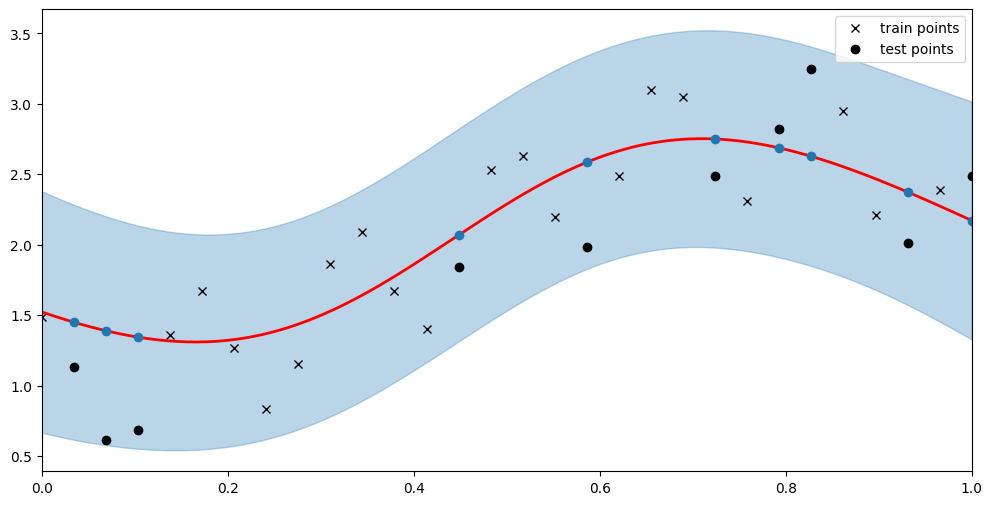

variance = 1.3034032583236694
lengthscale = 1.1538379192352295
period = 0.3476046919822693
noise = 0.2475873827934265
tensor(0.2237)


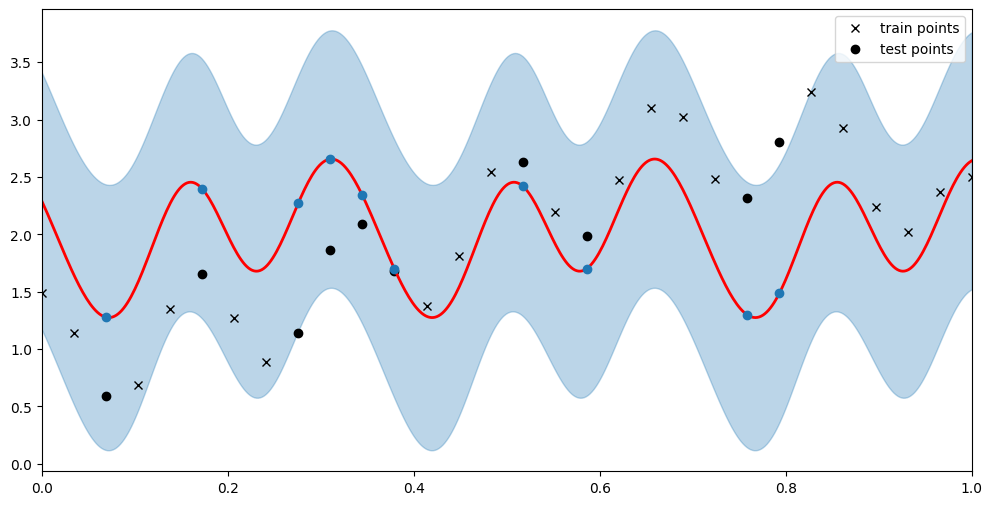

variance = 2.121363401412964
lengthscale = 0.4627695381641388
period = 1.0285953283309937
noise = 0.0004999425145797431
tensor(4.4410)


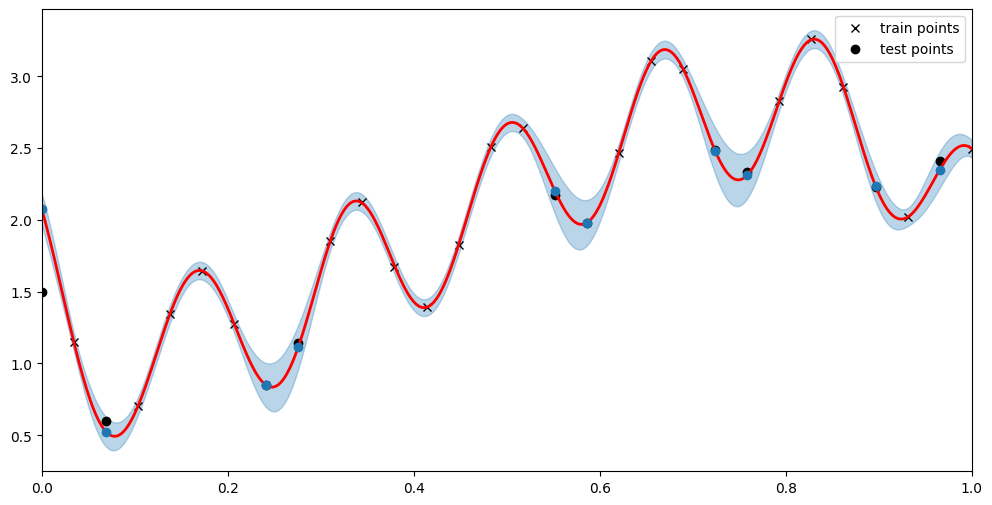

variance = 2.094618558883667
lengthscale = 0.2330574244260788
period = 0.5330812335014343
noise = 0.02040313556790352
tensor(-0.2223)


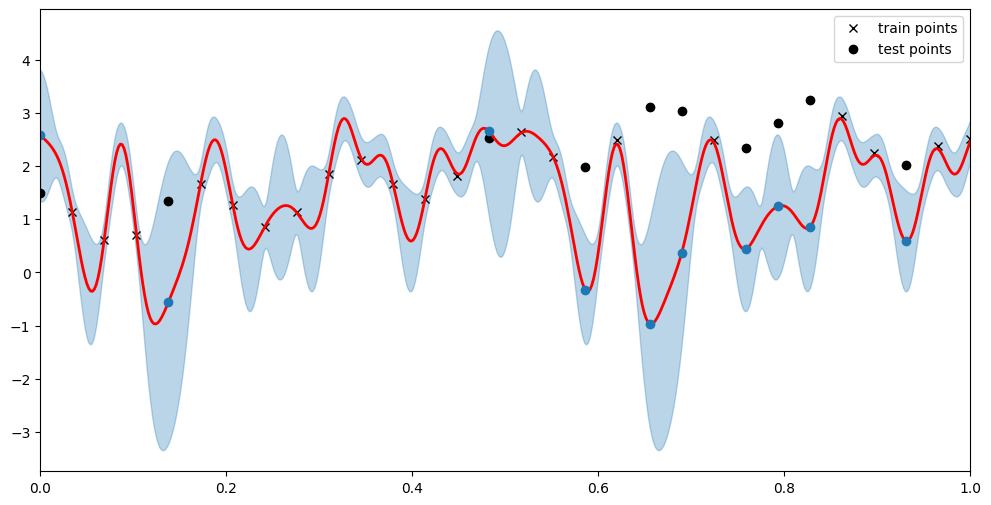

variance = 2.0012173652648926
lengthscale = 0.4277830719947815
period = 1.0679682493209839
noise = 0.009332418441772461
tensor(1.7003)


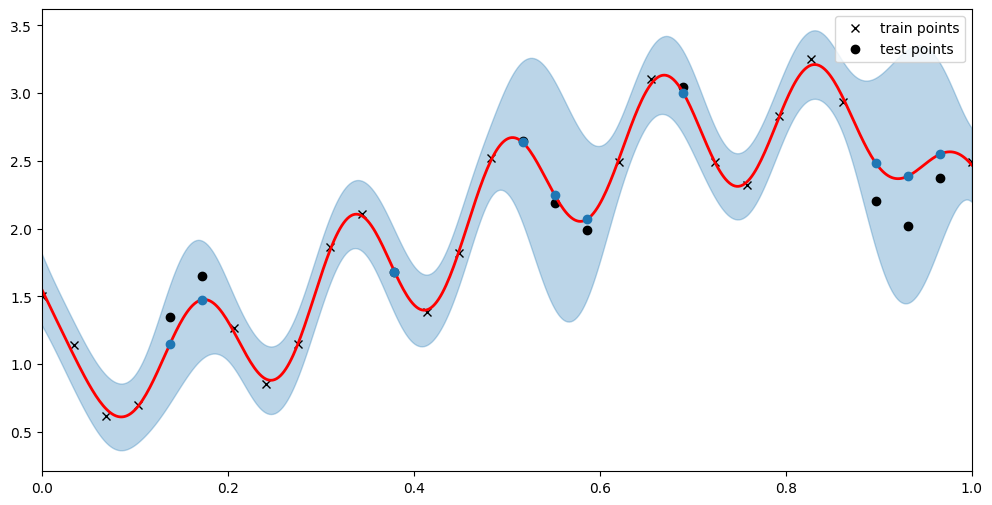

variance = 2.274972677230835
lengthscale = 0.37552109360694885
period = 0.831820547580719
noise = 0.005442983005195856
tensor(2.5063)


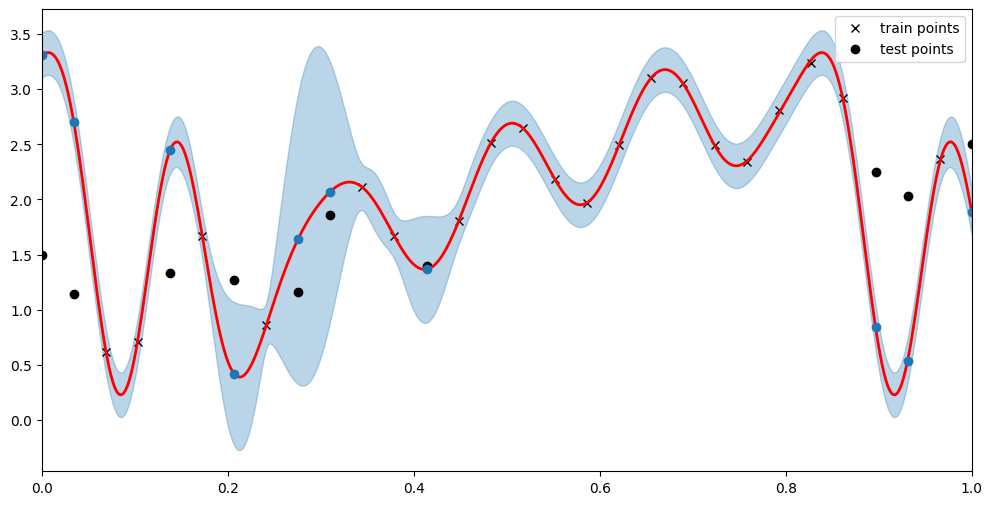

variance = 2.075216054916382
lengthscale = 0.45107197761535645
period = 1.0504398345947266
noise = 0.001163934706710279
tensor(4.1352)


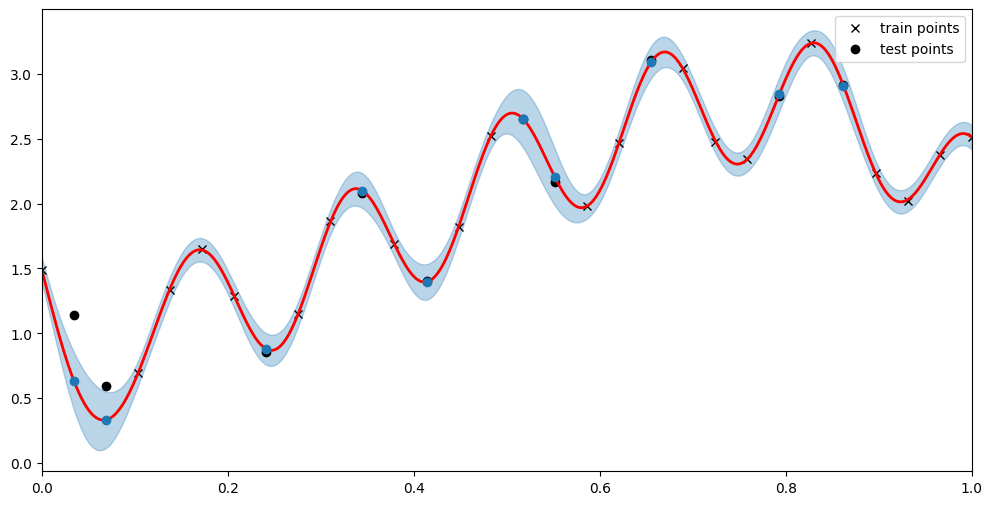

variance = 1.9600715637207031
lengthscale = 0.41823676228523254
period = 1.0857306718826294
noise = 0.00625837966799736
tensor(2.6817)


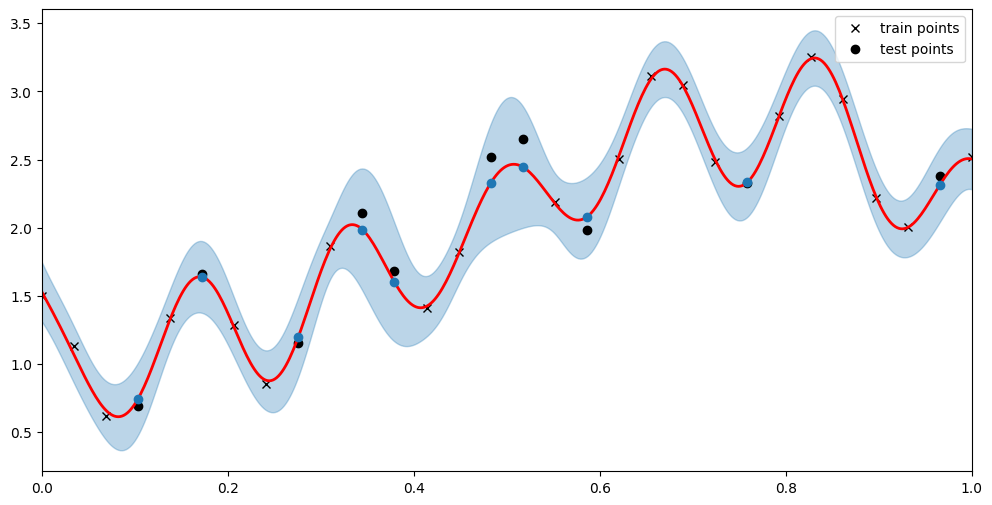

variance = 2.63873553276062
lengthscale = 0.1903970092535019
period = 0.536090612411499
noise = 0.020619232207536697
tensor(-1.1992)


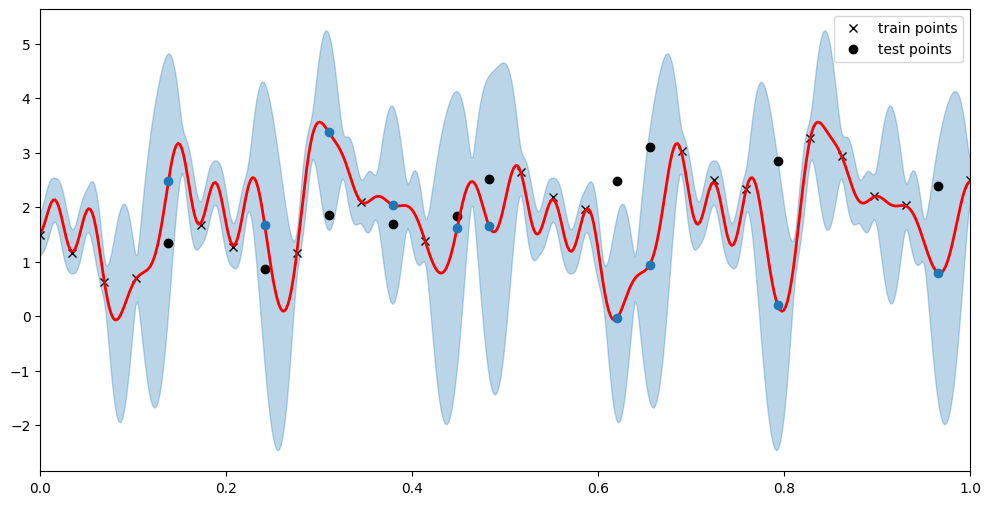

variance = 1.9855318069458008
lengthscale = 0.4239063262939453
period = 1.072124719619751
noise = 0.008911512792110443
tensor(2.6734)


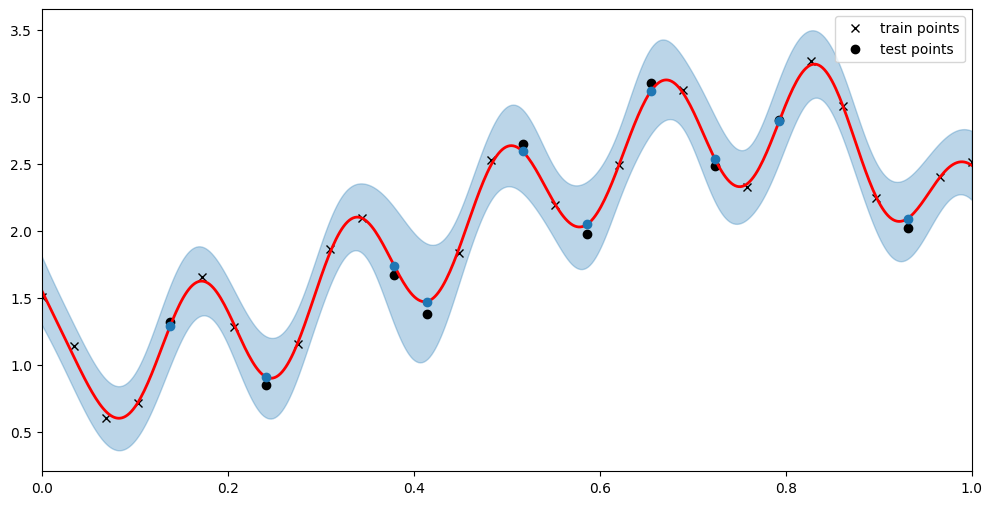

variance = 1.7477293014526367
lengthscale = 0.4770481586456299
period = 1.066425085067749
noise = 0.02366434410214424
tensor(1.4928)


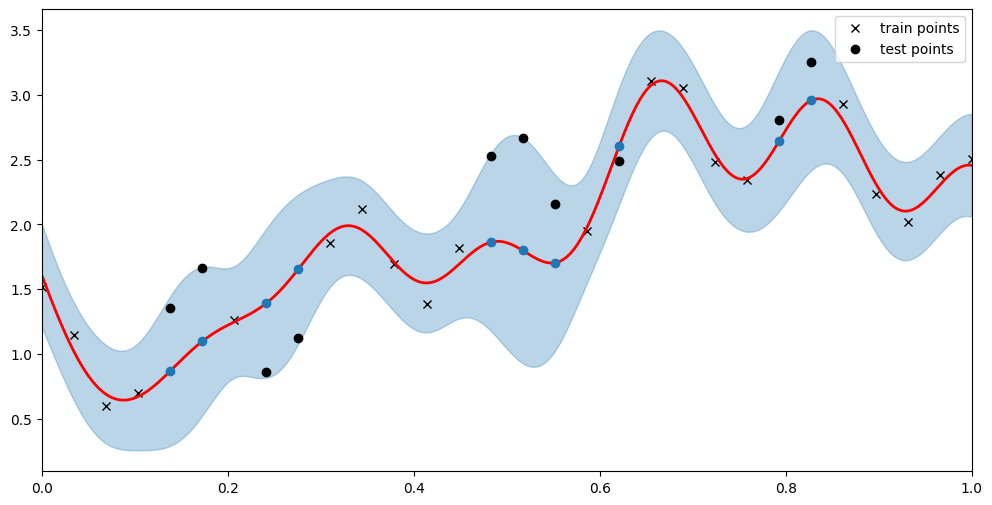

In [78]:
ypreds = []
testlikelihoods = []

# prior mean and var
mu = 0.
var = 0.5

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)


for k in range(20):
    pyro.clear_param_store()

    # define model
    kernel = gp.kernels.Periodic(
        input_dim=1
    )
    gpr = gp.models.GPRegression(xtrains[k], ytrains[k], kernel, noise=torch.tensor(0.01))

    # set priors on the kernel
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.set_mode("model")

    # perform gradient descent to optimize parameters
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # print params after training
    gpr.set_mode("guide")
    print("variance = {}".format(gpr.kernel.variance))
    print("lengthscale = {}".format(gpr.kernel.lengthscale))
    print("period = {}".format(gpr.kernel.period))
    print("noise = {}".format(gpr.noise))

    temp = []
    ms, s = gpr(xtests[k], full_cov=True, noiseless=False)
    for j in range(len(ms)):
        test_likelihood = torch.distributions.normal.Normal(ms[j], s[j, j]).log_prob(ms[j])
        temp.append(test_likelihood)
    temp = torch.tensor(temp)
    mean_temp = torch.mean(temp)
    print("Likelihood: ", mean_temp)
    testlikelihoods.append(mean_temp)

    # generate plot
    plot(model=gpr, X_train=xtrains[k], y_train=ytrains[k], X_test=xtests[k], y_test=ytests[k], posterior_test=xtests[k], plot_predictions=True)
    _ = plt.xlim(0, 1)
    plt.show()

    # plot_loss(losses)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]

Sample: 100%|██████████| 1000/1000 [00:42, 23.69it/s, step size=2.07e-01, acc. prob=0.694]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.41      0.05      0.42      0.32      0.49     40.76      1.03
       kernel.period      1.15      0.14      1.09      1.03      1.37     49.94      1.03
     kernel.variance      2.27      0.67      2.18      1.21      3.20     82.84      1.01

Number of divergences: 0
None
tensor(1.3243)


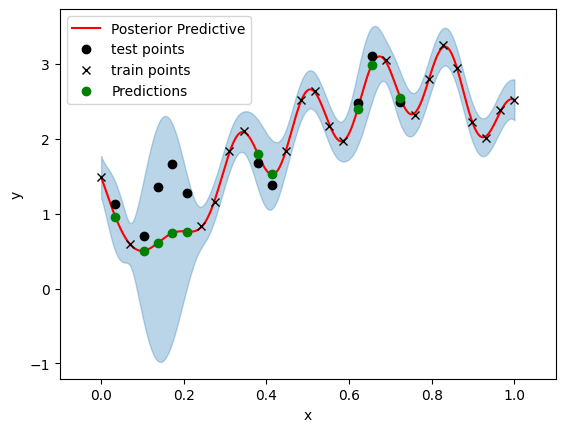

Sample: 100%|██████████| 1000/1000 [01:03, 15.64it/s, step size=3.00e-01, acc. prob=0.424]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.45      0.05      0.44      0.38      0.52     41.82      1.00
       kernel.period      1.10      0.08      1.07      1.04      1.19     63.82      1.00
     kernel.variance      2.40      0.88      2.16      1.33      3.69     42.55      1.01

Number of divergences: 0
None
tensor(1.9784)


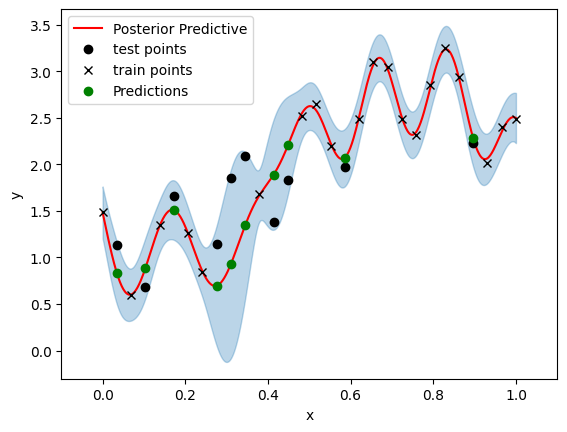

Sample: 100%|██████████| 1000/1000 [01:13, 13.60it/s, step size=3.43e-01, acc. prob=0.933]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.23      0.03      0.23      0.19      0.28    151.74      1.00
       kernel.period      0.27      0.00      0.27      0.27      0.27    420.98      1.00
     kernel.variance      2.83      0.74      2.74      1.63      3.97    170.29      1.00

Number of divergences: 0
None
tensor(-0.4586)


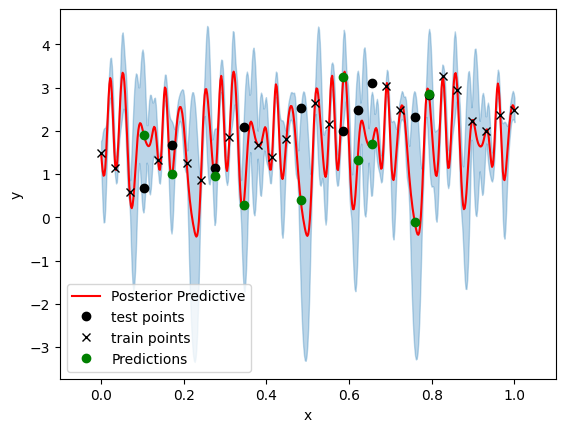

Sample: 100%|██████████| 1000/1000 [01:23, 11.91it/s, step size=3.43e-01, acc. prob=0.952]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.27      0.03      0.27      0.21      0.32    162.75      1.00
       kernel.period      0.21      0.00      0.21      0.21      0.21    197.79      1.00
     kernel.variance      2.73      0.74      2.65      1.54      3.77    213.43      1.00

Number of divergences: 0
None
tensor(0.9122)


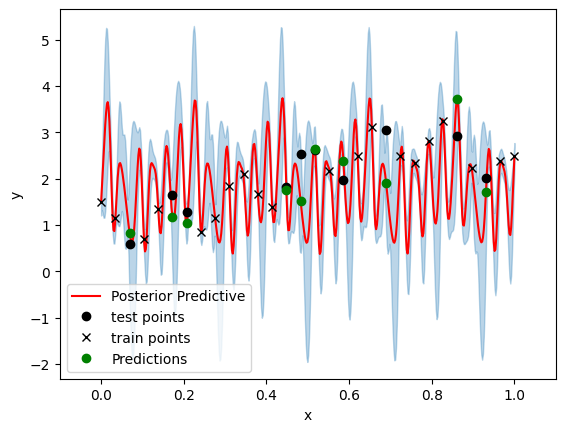

Sample: 100%|██████████| 1000/1000 [00:53, 18.77it/s, step size=2.31e-01, acc. prob=0.735]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.07      0.38      0.26      0.48     55.74      1.03
       kernel.period      1.26      0.23      1.17      1.04      1.58     64.89      1.02
     kernel.variance      2.38      0.70      2.27      1.27      3.33     95.15      1.00

Number of divergences: 2
None
tensor(2.0582)


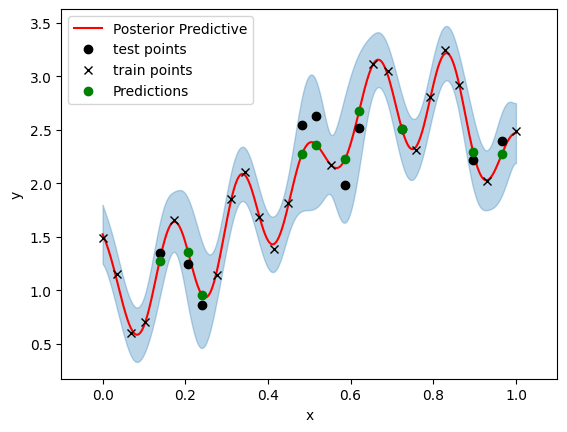

Sample: 100%|██████████| 1000/1000 [00:33, 29.61it/s, step size=3.32e-01, acc. prob=0.772]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.06      0.39      0.28      0.47     69.57      1.06
       kernel.period      1.25      0.20      1.17      1.03      1.51     67.89      1.04
     kernel.variance      2.38      0.77      2.24      1.19      3.28    109.92      1.00

Number of divergences: 0
None
tensor(2.1831)


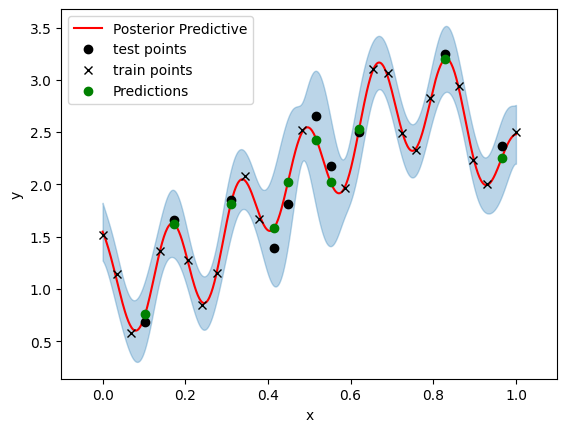

Sample: 100%|██████████| 1000/1000 [01:23, 11.94it/s, step size=2.52e-01, acc. prob=0.889]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.43      0.06      0.43      0.33      0.53    102.54      1.00
       kernel.period      0.14      0.00      0.14      0.14      0.14    106.76      1.00
     kernel.variance      2.39      0.73      2.32      1.31      3.41    117.85      1.00

Number of divergences: 0
None
tensor(1.9692)


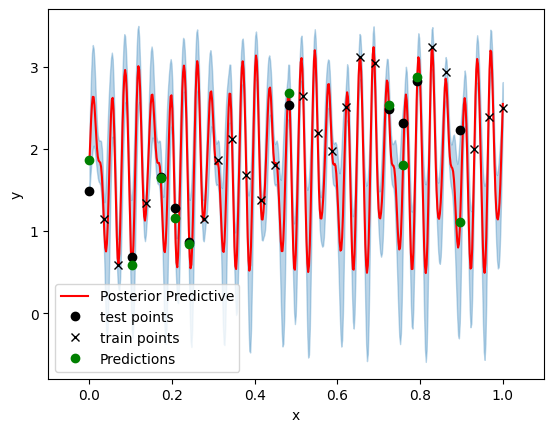

Sample: 100%|██████████| 1000/1000 [00:41, 24.16it/s, step size=1.80e-01, acc. prob=0.846]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.39      0.05      0.39      0.32      0.49     77.45      1.00
       kernel.period      1.20      0.16      1.15      1.04      1.42     82.35      1.00
     kernel.variance      2.34      0.81      2.18      1.29      3.33     92.85      1.00

Number of divergences: 0
None
tensor(2.6687)


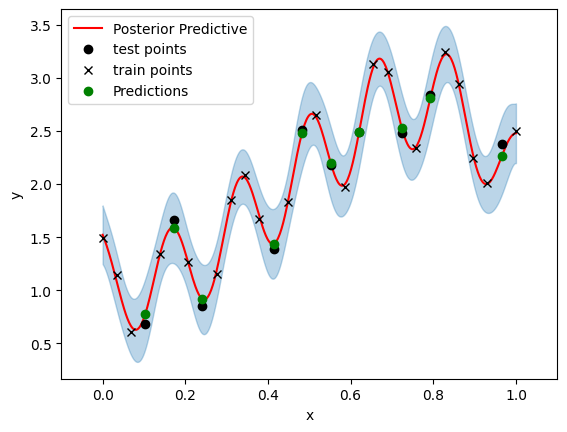

Sample: 100%|██████████| 1000/1000 [00:38, 26.21it/s, step size=3.57e-01, acc. prob=0.901]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.21      0.03      0.21      0.17      0.25    139.12      1.00
       kernel.period      0.35      0.00      0.35      0.35      0.36    137.85      1.00
     kernel.variance      2.85      0.78      2.71      1.65      4.03    175.51      1.00

Number of divergences: 1
None
tensor(-0.6486)


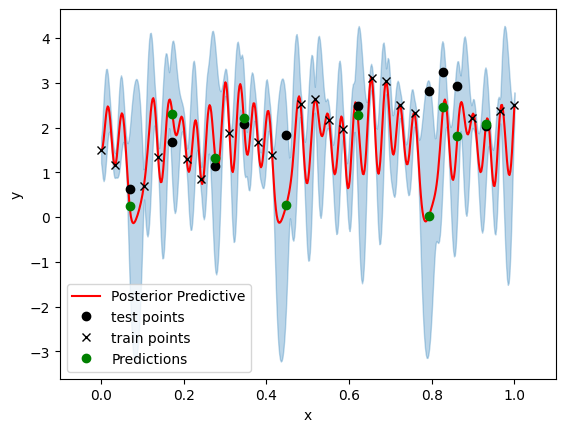

Sample: 100%|██████████| 1000/1000 [00:45, 21.74it/s, step size=1.83e-01, acc. prob=0.841]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.40      0.06      0.41      0.31      0.50     59.20      1.00
       kernel.period      1.16      0.20      1.09      0.99      1.42     54.29      1.01
     kernel.variance      2.25      0.75      2.14      1.18      3.41    141.12      1.02

Number of divergences: 3
None
tensor(1.6811)


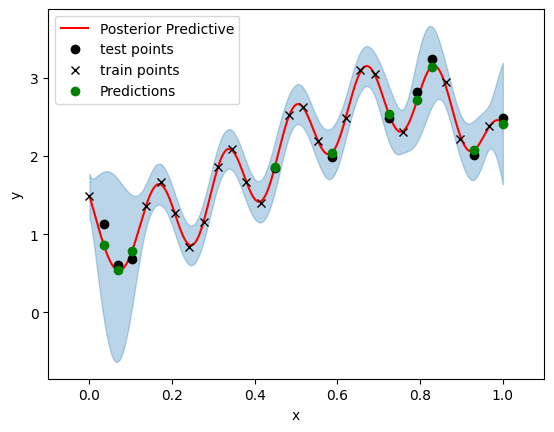

Sample: 100%|██████████| 1000/1000 [00:45, 21.89it/s, step size=2.51e-01, acc. prob=0.862]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.06      0.39      0.30      0.49     50.50      1.03
       kernel.period      1.24      0.20      1.17      1.04      1.49     46.97      1.04
     kernel.variance      2.11      0.58      2.02      1.13      2.96    217.54      1.00

Number of divergences: 0
None
tensor(1.7593)


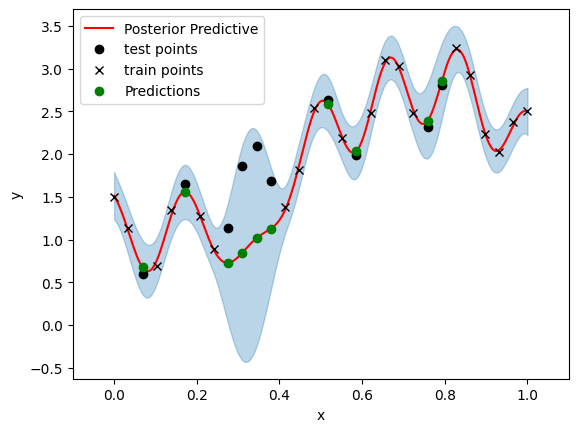

Sample: 100%|██████████| 1000/1000 [00:44, 22.49it/s, step size=2.32e-01, acc. prob=0.815]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.44      0.05      0.44      0.34      0.51     62.76      1.02
       kernel.period      1.10      0.12      1.06      1.00      1.22     62.46      1.02
     kernel.variance      2.47      0.74      2.30      1.40      3.74    117.09      1.00

Number of divergences: 0
None
tensor(2.1769)


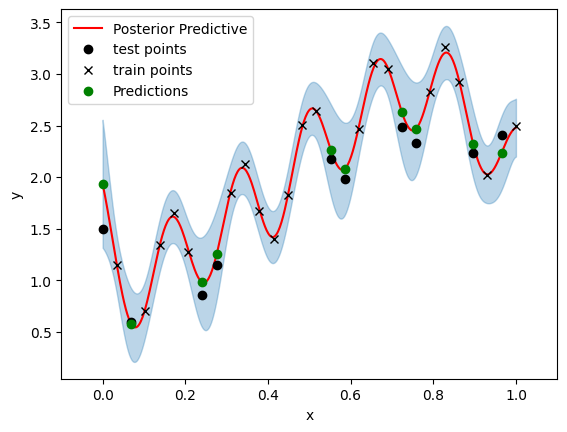

Sample: 100%|██████████| 1000/1000 [00:58, 17.03it/s, step size=1.39e-01, acc. prob=0.840]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.42      0.07      0.42      0.32      0.54     32.95      1.00
       kernel.period      1.14      0.20      1.06      1.01      1.37     25.56      1.01
     kernel.variance      2.36      0.78      2.22      1.17      3.49    103.05      1.00

Number of divergences: 0
None
tensor(1.6981)


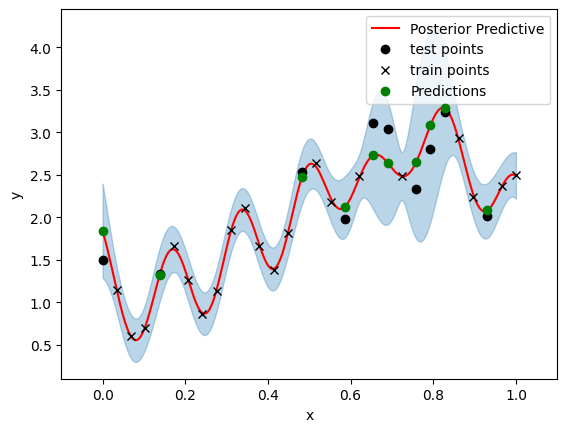

Sample: 100%|██████████| 1000/1000 [01:36, 10.37it/s, step size=2.21e-01, acc. prob=0.954]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.20      0.03      0.21      0.16      0.25    146.65      1.00
       kernel.period      0.16      0.00      0.16      0.16      0.16    263.05      1.00
     kernel.variance      3.14      0.84      3.01      1.73      4.35    137.06      1.00

Number of divergences: 1
None
tensor(-0.5956)


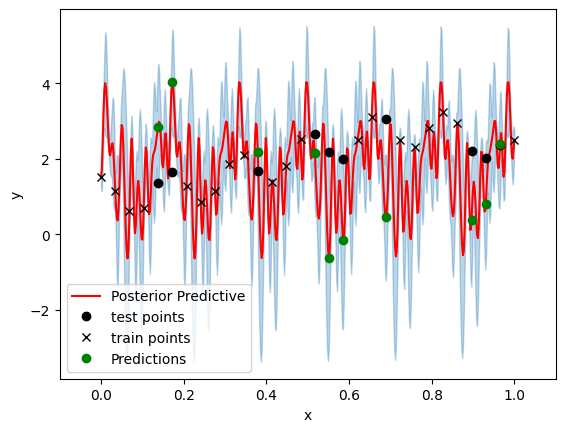

Sample: 100%|██████████| 1000/1000 [00:39, 25.12it/s, step size=3.11e-01, acc. prob=0.872]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.41      0.06      0.42      0.31      0.51     79.28      1.01
       kernel.period      1.13      0.18      1.06      0.95      1.40     59.11      1.03
     kernel.variance      2.37      0.67      2.30      1.41      3.32    252.96      1.00

Number of divergences: 2
None
tensor(1.5408)


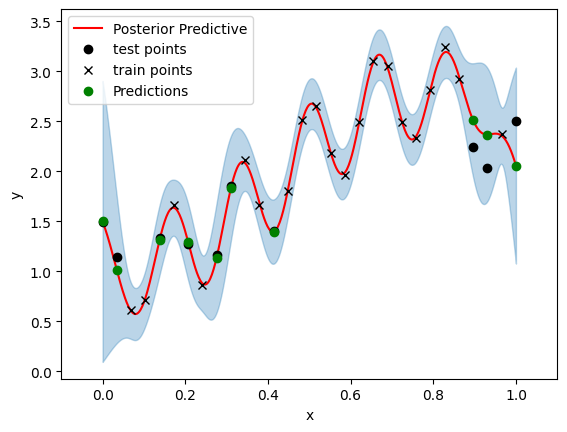

Sample: 100%|██████████| 1000/1000 [00:45, 21.82it/s, step size=1.50e-01, acc. prob=0.743]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.43      0.05      0.43      0.35      0.52     53.43      1.04
       kernel.period      1.11      0.10      1.07      1.03      1.25     55.11      1.05
     kernel.variance      2.62      0.85      2.60      1.26      3.86     80.78      1.00

Number of divergences: 0
None
tensor(2.4193)


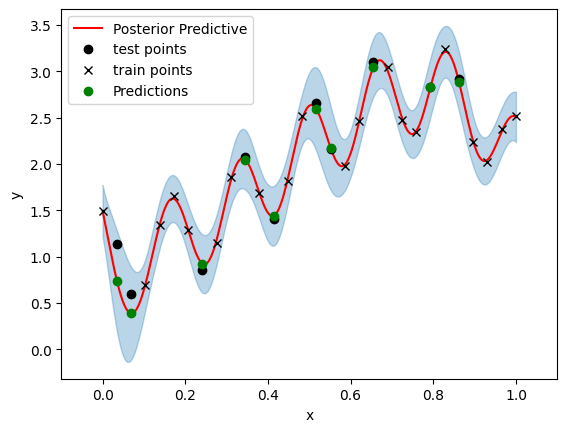

Sample: 100%|██████████| 1000/1000 [00:40, 24.75it/s, step size=2.23e-01, acc. prob=0.866]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.06      0.39      0.29      0.48     68.63      1.01
       kernel.period      1.24      0.23      1.16      1.03      1.49     65.36      1.01
     kernel.variance      2.25      0.64      2.15      1.28      3.16    215.31      1.00

Number of divergences: 0
None
tensor(2.3292)


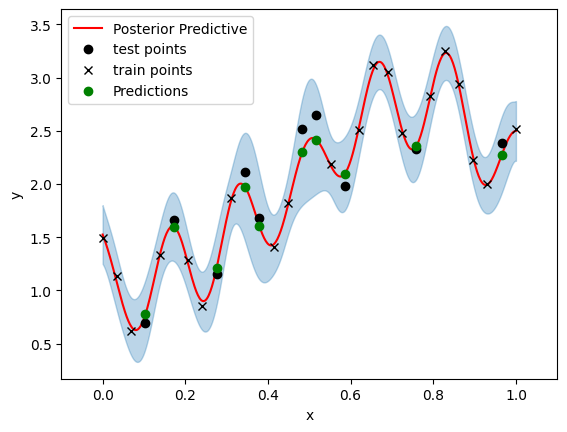

Sample: 100%|██████████| 1000/1000 [00:56, 17.61it/s, step size=3.45e-01, acc. prob=0.950]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.23      0.03      0.24      0.18      0.27    205.53      1.00
       kernel.period      0.35      0.00      0.35      0.35      0.35    199.83      1.00
     kernel.variance      2.81      0.80      2.64      1.71      4.23    264.62      1.00

Number of divergences: 0
None
tensor(-0.4599)


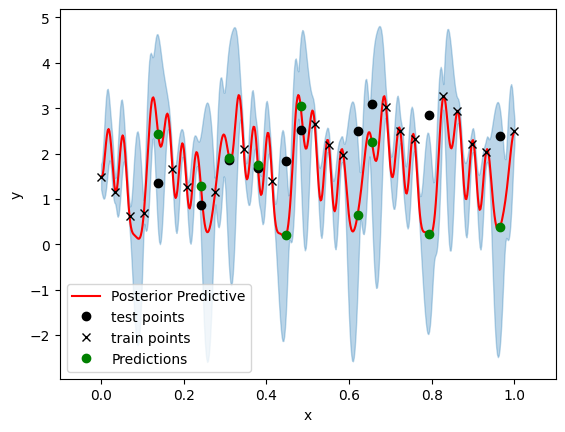

Sample: 100%|██████████| 1000/1000 [00:44, 22.64it/s, step size=5.93e-01, acc. prob=0.820]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.17      0.02      0.17      0.13      0.20    397.61      1.00
       kernel.period      0.71      0.00      0.71      0.70      0.71    353.08      1.00
     kernel.variance      3.32      0.88      3.16      1.99      4.66    204.64      1.00

Number of divergences: 13
None
tensor(-1.3366)


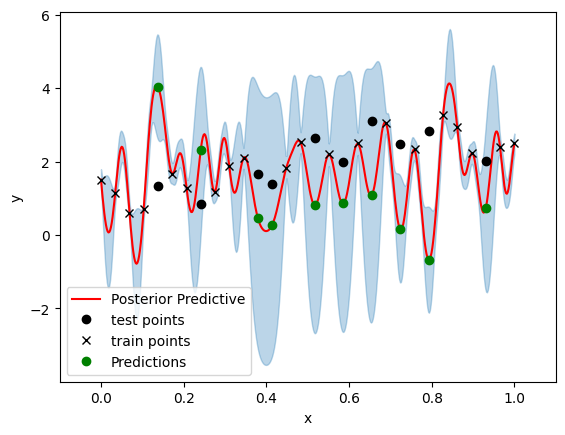

Sample: 100%|██████████| 1000/1000 [00:38, 26.13it/s, step size=3.69e-01, acc. prob=0.929]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.23      0.02      0.23      0.19      0.27    155.05      1.00
       kernel.period      0.37      0.00      0.37      0.37      0.37    200.78      1.00
     kernel.variance      3.03      0.94      2.84      1.67      4.20    175.11      1.00

Number of divergences: 3
None
tensor(-0.4956)


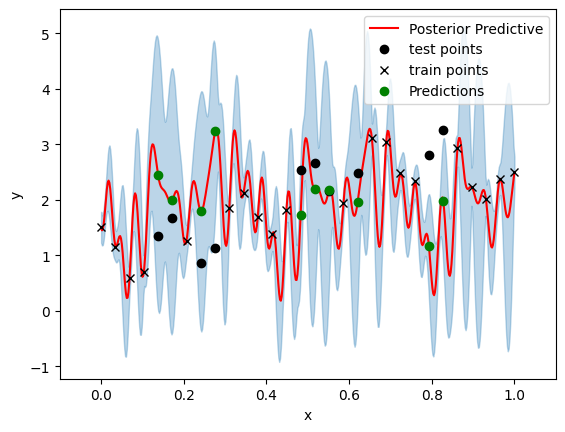

In [91]:
testlikelihoods_NUTS = []

# sample using NUTS
n_samples = 500
n_chains = 1
n_warmup = 200

# prior mean and var
mu = 0.
var = 0.5

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)


for k in range(20):
    pyro.clear_param_store()

    # define model
    kernel = gp.kernels.Periodic(
        input_dim=1
    )
    gpr = gp.models.GPRegression(xtrains[k], ytrains[k], kernel, noise=torch.tensor(0.01))

    # set priors on the kernel
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.set_mode("model")

    # perform NUTS to sample from posterior

    # compute second moment quantity
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples,
                        num_chains=n_chains)
    mcmc.run()
    samples = mcmc.get_samples()
    print(mcmc.summary())
    
    means = []
    means_all = []
    linspace = torch.linspace(0, 1, 500)
    s = 0
    s_all = 0
    for i in range(500):
        gpr.kernel.lengthscale = samples['kernel.lengthscale'][i]
        gpr.kernel.variance = samples['kernel.variance'][i]
        gpr.kernel.period = samples['kernel.period'][i]

        m_all, variances_all = gpr(linspace, full_cov=True, noiseless=False)
        m, variances = gpr(xtests[k], full_cov=True, noiseless=False)
        means.append(m.detach().cpu().numpy())
        s += variances
        means_all.append(m_all.detach().cpu().numpy())
        s_all += variances_all

    ms = torch.mean(torch.tensor(means), axis=0)
    s = s / 500
    ms_all = torch.mean(torch.tensor(means_all), axis=0)
    s_all = s_all / 500


    temp = []
    for j in range(len(ms)):
        test_likelihood = torch.distributions.normal.Normal(ms[j], s[j, j]).log_prob(ms[j])
        temp.append(test_likelihood)
    temp = torch.tensor(temp)
    mean_temp = torch.mean(temp)
    print("Likelihood: ", mean_temp)
    testlikelihoods_NUTS.append(mean_temp)

    # generate plot
    plt.plot(linspace, ms_all, c='red', label='Posterior Predictive')
    plt.plot(xtests[k].numpy(), ytests[k], "ko", label="test points")
    plt.plot(xtrains[k].numpy(), ytrains[k], "kx", label="train points")
    plt.plot(xtests[k].numpy(), ms, "go", zorder=10, label="Predictions")
    sd = s_all.diag().sqrt()  # standard deviation at each input point x
    plt.fill_between(
        linspace.numpy(),  # plot the two-sigma uncertainty about the mean
        (ms_all - 2.0 * sd.detach().cpu().numpy()).numpy(),
        (ms_all + 2.0 * sd.detach().cpu().numpy()).numpy(),
        color="C0",
        alpha=0.3,
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    _ = plt.xlim(-0.1, 1.1)
    plt.show()

    # plot_loss(losses)

In [93]:
avg_likelihood_NUTS = torch.mean(torch.tensor(testlikelihoods_NUTS))
avg_likelihood_MAP = torch.mean(torch.tensor(testlikelihoods))

print('Average likelihood over the 20 experiments using MAP: ', avg_likelihood_MAP)
print('Average likelihood over the 20 experiments using NUTS: ', avg_likelihood_NUTS)

Average likelihood over the 20 experiments using MAP:  tensor(1.6494)
Average likelihood over the 20 experiments using NUTS:  tensor(1.1352)
